# Prediciendo precios de divisas con Redes Neuronales concurso Siraj Raval

Predecimos EURUSD

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Datos

In [2]:
dataset = pd.read_csv('TSLAti.csv')
dataset.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,34.28,33.59,-0.022938,40.11976,0.8
1,33.59,33.69,-0.057940,0.00000,1.0


### Normalizamos

In [3]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,-0.515529,-0.518121,-0.001110,-0.165436,-0.169220
1,-0.517489,-0.517837,-0.002761,-0.566634,-0.164405


## Hyperparamétros

In [4]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #Tamaños de la secuencia

state_size = 20 #Número de neuronas

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 20

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1268
The current configuration gives us 422 batches of 1 observations each one looking 3 steps in the past


## Entrenamiento y prueba: conjuntos

In [5]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [6]:
datasetTrain.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
0,-0.515529,-0.518121,-0.001110,-0.165436,-0.169220
1,-0.517489,-0.517837,-0.002761,-0.566634,-0.164405


In [7]:
datasetTest.head(2)

,Close,CloseTarget,MACD,Stochastics,ATR
1247,0.249673,0.276193,0.058127,-0.566634,-0.019966
1248,0.276825,0.270456,0.081169,0.110900,0.133861


In [8]:
xTrain = datasetTrain[['Close','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [9]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.51552895 -0.00110981 -0.16543647 -0.16922004]
 [-0.51748867 -0.00276148 -0.56663407 -0.16440541]
 [-0.51720465 -0.00351081 -0.50746247 -0.16657199]] 
 [-0.51812099 -0.51783698 -0.51917186]


In [10]:
xTest = datasetTest[['Close','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [11]:
print(xTest[0:3],'\n',yTest[0:3])

[[ 0.24967313  0.0581268  -0.56663407 -0.01996631]
 [ 0.27682528  0.0811686   0.11089959  0.13386132]
 [ 0.27108811  0.09104171 -0.03226129 -0.00600387]] 
 [ 0.27619296  0.27045579  0.2815041 ]


## Visualizamos el precio

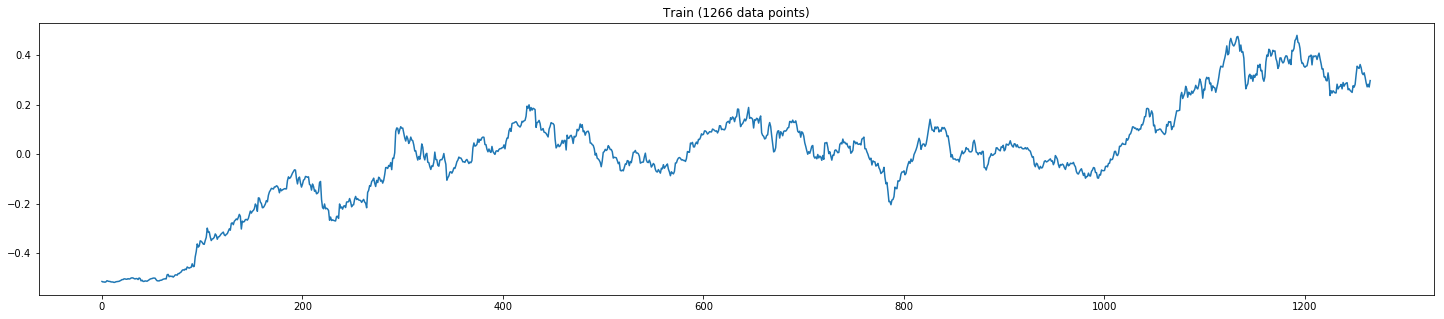

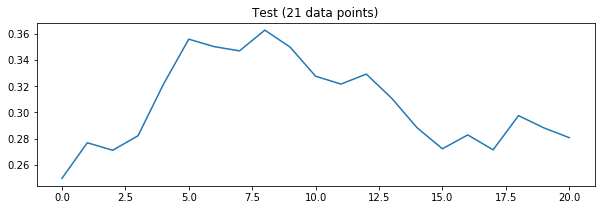

In [12]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Marcadores

In [13]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Pesos y biases
Red de 3 capas:
1. Input entrada
2. Hidden Recurrent layer
3. Output Salida

Necesitamos dos pares de W y b

In [14]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Desenrrollamos

In [15]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Hacia adelante (foward propagation)

Entrada a unidad Recurrente

In [16]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [17]:
states_series = tf.transpose(states_series,[1,0,2])

## Paso hacia atrás - Salida

In [18]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Pesos y bias de salida

In [19]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Predicciones, func pérdida & optimizador

In [20]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [21]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                

    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][-1]) #The last one

Epoch 0
Step 0 - Loss: 0.009863
Step 50 - Loss: 0.050040
Step 100 - Loss: 0.004497
Step 150 - Loss: 0.762386
Step 200 - Loss: 0.001242
Step 250 - Loss: 0.035153
Step 300 - Loss: 0.039604
Step 350 - Loss: 0.005540
Step 400 - Loss: 0.012586
Epoch 1
Step 0 - Loss: 0.004360
Step 50 - Loss: 0.001086
Step 100 - Loss: 0.000002
Step 150 - Loss: 0.025341
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000631
Step 300 - Loss: 0.003129
Step 350 - Loss: 0.000033
Step 400 - Loss: 0.007159
Epoch 2
Step 0 - Loss: 0.023880
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.001282
Step 150 - Loss: 0.000217
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000275
Step 300 - Loss: 0.000863
Step 350 - Loss: 0.000695
Step 400 - Loss: 0.005016
Epoch 3
Step 0 - Loss: 0.050716
Step 50 - Loss: 0.000069
Step 100 - Loss: 0.002931
Step 150 - Loss: 0.001972
Step 200 - Loss: 0.000016
Step 250 - Loss: 0.000392
Step 300 - Loss: 0.000538
Step 350 - Loss: 0.001144
Step 400 - Loss: 0.004025
Epoch 4
Step 0 - Loss: 0.056887
Step 50 - Lo

Step 100 - Loss: 0.000149
Step 150 - Loss: 0.000343
Step 200 - Loss: 0.000050
Step 250 - Loss: 0.000340
Step 300 - Loss: 0.000205
Step 350 - Loss: 0.000278
Step 400 - Loss: 0.001358
Epoch 35
Step 0 - Loss: 0.011947
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000161
Step 150 - Loss: 0.000337
Step 200 - Loss: 0.000048
Step 250 - Loss: 0.000333
Step 300 - Loss: 0.000209
Step 350 - Loss: 0.000261
Step 400 - Loss: 0.001327
Epoch 36
Step 0 - Loss: 0.011486
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000173
Step 150 - Loss: 0.000328
Step 200 - Loss: 0.000046
Step 250 - Loss: 0.000327
Step 300 - Loss: 0.000215
Step 350 - Loss: 0.000247
Step 400 - Loss: 0.001297
Epoch 37
Step 0 - Loss: 0.011059
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000314
Step 200 - Loss: 0.000043
Step 250 - Loss: 0.000322
Step 300 - Loss: 0.000221
Step 350 - Loss: 0.000234
Step 400 - Loss: 0.001266
Epoch 38
Step 0 - Loss: 0.010652
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000197
Step 150 - Los

Step 300 - Loss: 0.000227
Step 350 - Loss: 0.000186
Step 400 - Loss: 0.000768
Epoch 69
Step 0 - Loss: 0.005840
Step 50 - Loss: 0.000037
Step 100 - Loss: 0.000266
Step 150 - Loss: 0.000474
Step 200 - Loss: 0.000034
Step 250 - Loss: 0.000105
Step 300 - Loss: 0.000219
Step 350 - Loss: 0.000178
Step 400 - Loss: 0.000724
Epoch 70
Step 0 - Loss: 0.006060
Step 50 - Loss: 0.000017
Step 100 - Loss: 0.000135
Step 150 - Loss: 0.000572
Step 200 - Loss: 0.000049
Step 250 - Loss: 0.000082
Step 300 - Loss: 0.000221
Step 350 - Loss: 0.000184
Step 400 - Loss: 0.000739
Epoch 71
Step 0 - Loss: 0.005698
Step 50 - Loss: 0.000046
Step 100 - Loss: 0.000252
Step 150 - Loss: 0.000490
Step 200 - Loss: 0.000037
Step 250 - Loss: 0.000097
Step 300 - Loss: 0.000208
Step 350 - Loss: 0.000182
Step 400 - Loss: 0.000693
Epoch 72
Step 0 - Loss: 0.005946
Step 50 - Loss: 0.000013
Step 100 - Loss: 0.000121
Step 150 - Loss: 0.000489
Step 200 - Loss: 0.000044
Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000216
Step 350 - Los

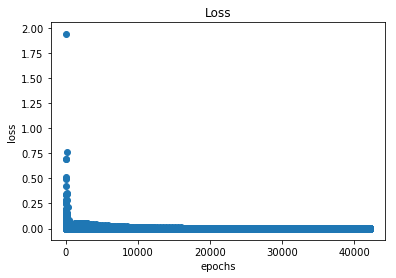

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

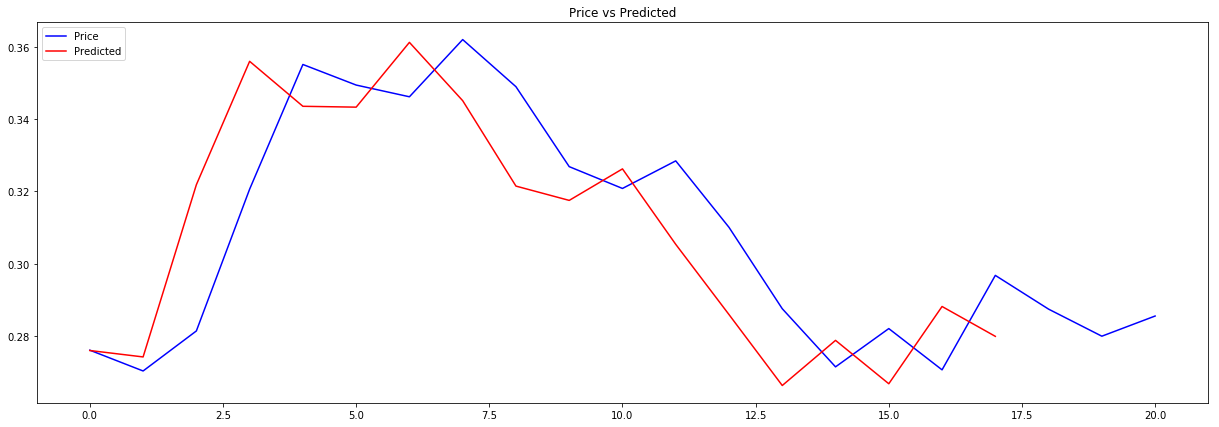

In [24]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()